## **IMPORTS**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
import re
import string
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
DEFAULT_SEED: int = 1234
np.random.seed(DEFAULT_SEED)

In [3]:
from nltk.corpus import wordnet, stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import defaultdict
from keras.preprocessing.text import Tokenizer
from nltk import pos_tag, word_tokenize
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputClassifier

## **DATA ANALYSIS**

In [4]:
train_data = pd.read_csv("D:/PROJECTS/SLP/train.csv")

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
labels = list(train_data.columns.values)
labels = labels[2:]
print(labels)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [10]:
counts = []
for label in labels:
    counts.append((label, train_data[label].sum()))
df_stats = pd.DataFrame(counts, columns=['label', 'number_of_comments'])
df_stats

,label,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


In [11]:
train_data["Non-Toxic"]=train_data["toxic"]+train_data["severe_toxic"]+train_data["obscene"]+train_data["threat"]+train_data["insult"]+train_data["identity_hate"]
train_data["Non-Toxic"] = train_data["Non-Toxic"].apply(lambda x: 0 if x > 0 else 1)
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Non-Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [12]:
data=[["Non-toxic",sum(train_data["Non-Toxic"]==1),17000],["Toxic",sum(train_data["toxic"]==1),3000],["Total",sum(train_data["Non-Toxic"]==0)+(sum(train_data["toxic"]==1)),17000+3000]]
df=pd.DataFrame(data,columns=["Category","No. of comments","Experimental data"])
df

,Category,No. of comments,Experimental data
0,Non-toxic,143346,17000
1,Toxic,15294,3000
2,Total,31519,20000


In [13]:
df_toxic=train_data[train_data["toxic"] == 1]
df_non_toxic=train_data[train_data["Non-Toxic"] == 1]
df_non_toxic=df_non_toxic.sample(n=17000)
df_toxic=df_toxic.sample(n=3000)
train_data=pd.concat([df_non_toxic,df_toxic])

## **VISUALIZATION**

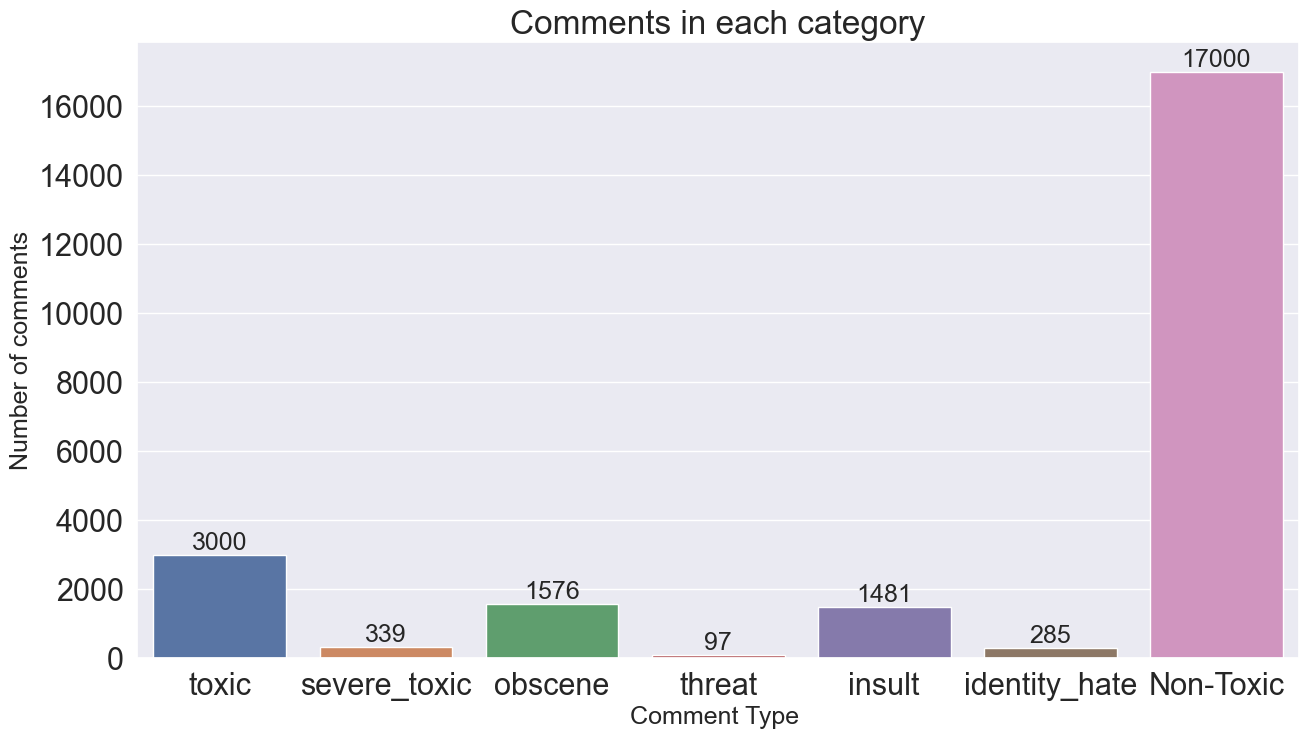

In [14]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
labels = list(train_data.columns.values)
labels = labels[2:]
ax= sns.barplot(x=labels, y=train_data.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
rects = ax.patches
categories = train_data.iloc[:,2:].sum().values
for rect, label in zip(rects, categories):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

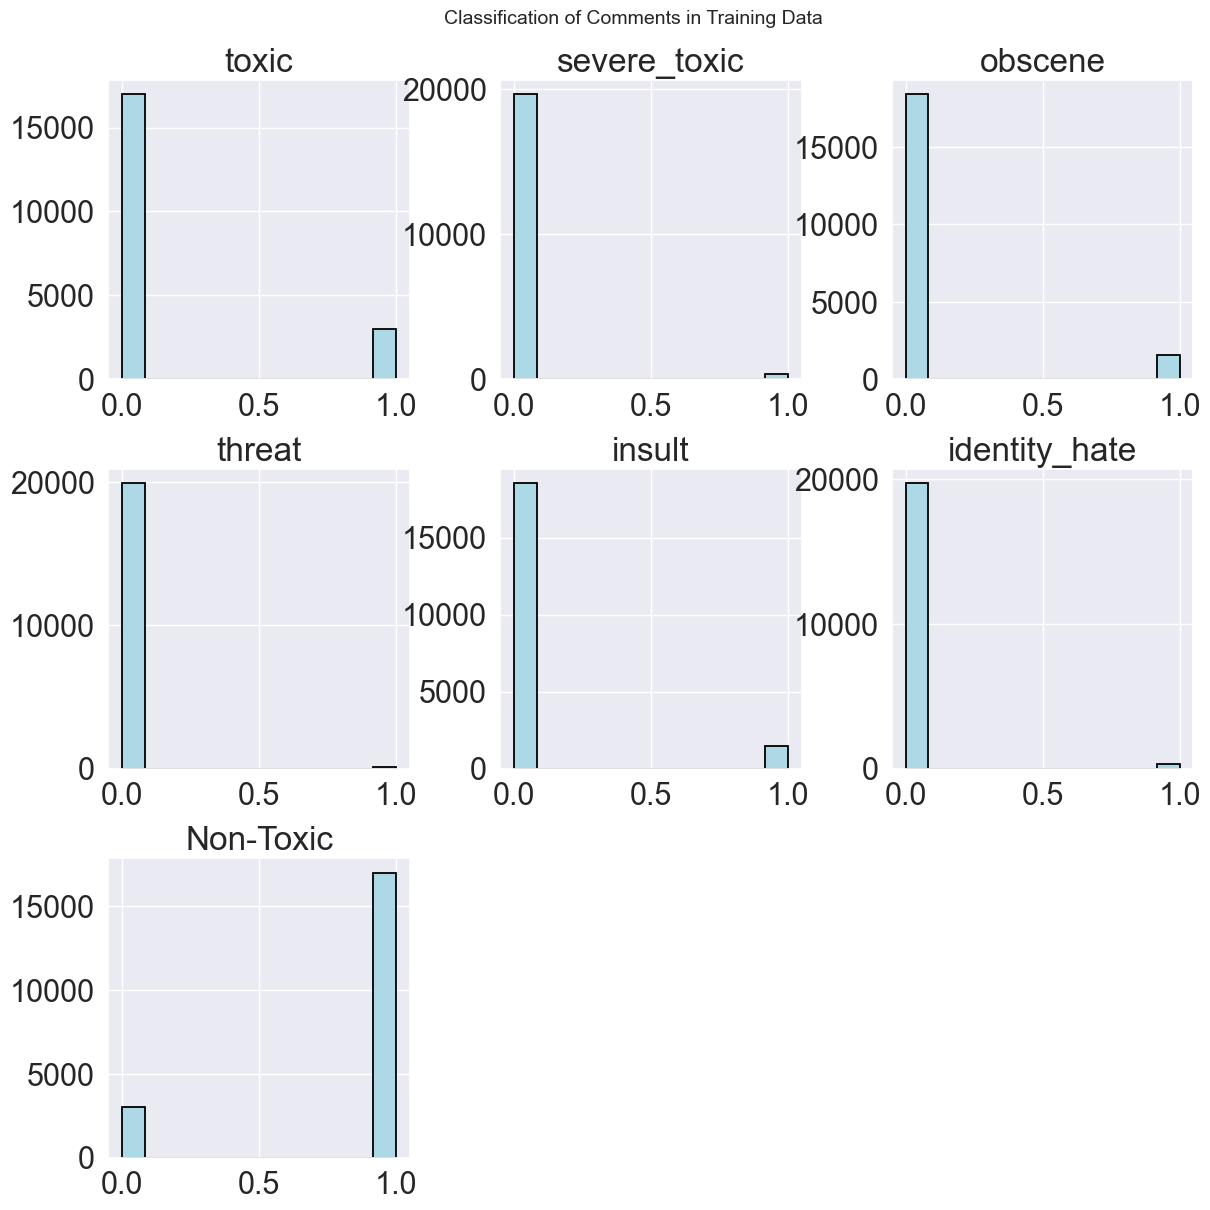

In [15]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train_data.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

From the visualization, we can observe that there is a high imbalance among the classes of the dataset since most of the values are zero for all classes

In [16]:
new_train=train_data.drop('Non-Toxic',axis=1)
new_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
61261,a3f914cd4dd316d6,"Yes, Reversider is of course completely correc...",0,0,0,0,0,0
110119,4cfc702c178efcfe,"Try harder, the evidence is even on Wiki Fred ...",0,0,0,0,0,0
13990,24e8981f0a44c253,"""\n I know you are writing these things in goo...",0,0,0,0,0,0
144893,1428ccef24ccb4a8,Arktos the troublemaker and wik vandal who doe...,0,0,0,0,0,0
50416,86cc47ea53fffb00,""", and welcome to Wikipedia! Thank you for you...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
69152,b905c67ac1638a2c,"""\n\nThat's ridiculous! Have you never read V...",1,0,0,0,0,0
78004,d0d4d9d54856ef6a,If you don't like it. You can kiss my Rebel ass.,1,0,1,0,1,0
131269,be60e6cb9f1cf073,I am going to kill you \n\ni am going to get ...,1,1,0,1,0,0
120068,8218f04b4988ca45,"You are a dumb flower \n\nNow, normally, I do ...",1,0,0,0,1,0


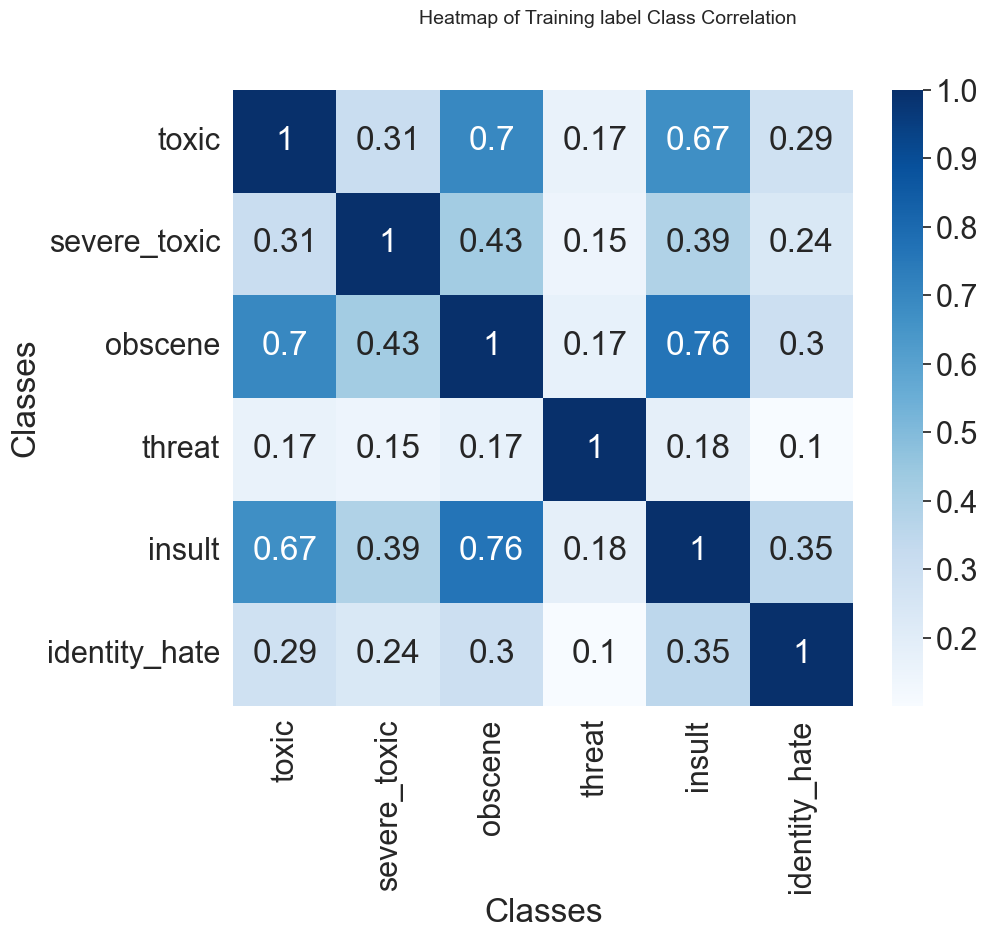

In [17]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(new_train.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [18]:
correlation_val =  new_train.corr()
abs(correlation_val) >= 0.6

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,True,False,True,False,True,False
severe_toxic,False,True,False,False,False,False
obscene,True,False,True,False,True,False
threat,False,False,False,True,False,False
insult,True,False,True,False,True,False
identity_hate,False,False,False,False,False,True


There exists high positive correlation between:
 1. insult and obsene
 2. toxic and obsene
 3. toxic and insult

In [19]:
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']

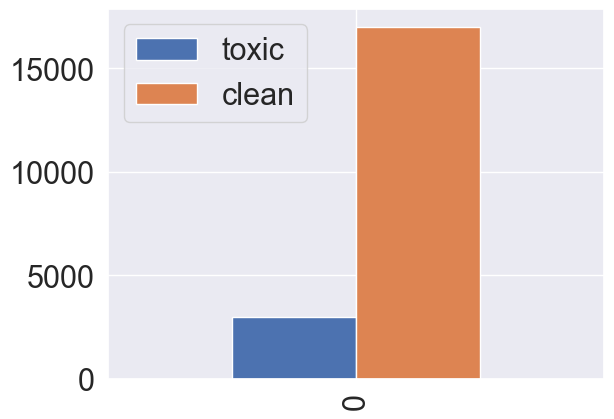

In [20]:
train_toxic_comments = train_data[train_data[labels].sum(axis=1) > 0]
train_clean_comments = train_data[train_data[labels].sum(axis=1) == 0]
pd.DataFrame(dict( toxic=[len(train_toxic_comments)], clean=[len(train_clean_comments)])).plot(kind='bar');

## **PRE-PROCESSING**

PUNCTUATION REMOVAL

In [21]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
train_data['comment_text']= train_data['comment_text'].apply(lambda x:remove_punctuation(x))

In [22]:
train_data["comment_text"]

61261     Yes Reversider is of course completely correct...
110119    Try harder the evidence is even on Wiki Fred R...
13990     \n I know you are writing these things in good...
144893    Arktos the troublemaker and wik vandal who doe...
50416      and welcome to Wikipedia Thank you for your c...
                                ...                        
69152     \n\nThats ridiculous  Have you never read Viz ...
78004         If you dont like it You can kiss my Rebel ass
131269    I am going to kill you  \n\ni am going to get ...
120068    You are a dumb flower \n\nNow normally I do no...
144958                       leave wikipedia you are stupid
Name: comment_text, Length: 20000, dtype: object

LOWERING THE TEXT

In [23]:
train_data['comment_text']= train_data['comment_text'].apply(lambda x: x.lower())

In [24]:
train_data["comment_text"]

61261     yes reversider is of course completely correct...
110119    try harder the evidence is even on wiki fred r...
13990     \n i know you are writing these things in good...
144893    arktos the troublemaker and wik vandal who doe...
50416      and welcome to wikipedia thank you for your c...
                                ...                        
69152     \n\nthats ridiculous  have you never read viz ...
78004         if you dont like it you can kiss my rebel ass
131269    i am going to kill you  \n\ni am going to get ...
120068    you are a dumb flower \n\nnow normally i do no...
144958                       leave wikipedia you are stupid
Name: comment_text, Length: 20000, dtype: object

CLEANING

In [25]:
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result
train_data['comment_text']= train_data['comment_text'].apply(lambda x: remove_numbers(x))

In [26]:
def remove_links(text):
    result = re.sub(r'^https?:\/\/.*[\s]*', '', text)
    return result
train_data['comment_text']= train_data['comment_text'].apply(lambda x: remove_links(x))

In [27]:
def remove_n(text):
    result = re.sub(r'\n', '', text)
    return result
train_data['comment_text']= train_data['comment_text'].apply(lambda x: remove_n(x))

In [28]:
train_data["comment_text"]

61261     yes reversider is of course completely correct...
110119    try harder the evidence is even on wiki fred r...
13990      i know you are writing these things in good f...
144893    arktos the troublemaker and wik vandal who doe...
50416      and welcome to wikipedia thank you for your c...
                                ...                        
69152     thats ridiculous  have you never read viz  loo...
78004         if you dont like it you can kiss my rebel ass
131269    i am going to kill you  i am going to get a gu...
120068    you are a dumb flower now normally i do not us...
144958                       leave wikipedia you are stupid
Name: comment_text, Length: 20000, dtype: object

TOKENIZATION

In [29]:
def tokenization(text):
    tokens = word_tokenize(text)
    return tokens
train_data['comment_text']= train_data['comment_text'].apply(lambda x: tokenization(x))

In [30]:
train_data["comment_text"]

61261     [yes, reversider, is, of, course, completely, ...
110119    [try, harder, the, evidence, is, even, on, wik...
13990     [i, know, you, are, writing, these, things, in...
144893    [arktos, the, troublemaker, and, wik, vandal, ...
50416     [and, welcome, to, wikipedia, thank, you, for,...
                                ...                        
69152     [thats, ridiculous, have, you, never, read, vi...
78004     [if, you, dont, like, it, you, can, kiss, my, ...
131269    [i, am, going, to, kill, you, i, am, going, to...
120068    [you, are, a, dumb, flower, now, normally, i, ...
144958                 [leave, wikipedia, you, are, stupid]
Name: comment_text, Length: 20000, dtype: object

STOP WORDS REMOVAL

In [31]:
stop_words=set(stopwords.words('english'))
def remove_stopwords(text):
    output= [i for i in text if i not in stop_words]
    return output
train_data['comment_text']= train_data['comment_text'].apply(lambda x:remove_stopwords(x))

In [32]:
train_data["comment_text"]

61261     [yes, reversider, course, completely, correct,...
110119    [try, harder, evidence, even, wiki, fred, r, k...
13990     [know, writing, things, good, faith, yop, clai...
144893    [arktos, troublemaker, wik, vandal, doesnt, sk...
50416     [welcome, wikipedia, thank, contributions, hop...
                                ...                        
69152     [thats, ridiculous, never, read, viz, look, th...
78004                        [dont, like, kiss, rebel, ass]
131269    [going, kill, going, get, gun, blow, head, stu...
120068    [dumb, flower, normally, use, term, explicitly...
144958                           [leave, wikipedia, stupid]
Name: comment_text, Length: 20000, dtype: object

STEMMING

In [33]:
stemmer = PorterStemmer()
def stemming(text):
  stem_text=[stemmer.stem(word) for word in text]
  return stem_text
train_data['comment_text']=train_data['comment_text'].apply(lambda x: stemming(x))

In [34]:
train_data["comment_text"]

61261     [ye, reversid, cours, complet, correct, would,...
110119    [tri, harder, evid, even, wiki, fred, r, klenn...
13990     [know, write, thing, good, faith, yop, claim, ...
144893    [arkto, troublemak, wik, vandal, doesnt, skill...
50416     [welcom, wikipedia, thank, contribut, hope, li...
                                ...                        
69152     [that, ridicul, never, read, viz, look, there,...
78004                        [dont, like, kiss, rebel, ass]
131269    [go, kill, go, get, gun, blow, head, stupid, r...
120068    [dumb, flower, normal, use, term, explicitli, ...
144958                            [leav, wikipedia, stupid]
Name: comment_text, Length: 20000, dtype: object

**FREQUENT WORDS**

In [35]:
wordfreq = {}
for tokens in train_data["comment_text"]:
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [36]:
topWords=sorted(wordfreq.items(), key=lambda x:x[-1],reverse=True)
len(topWords)

51816

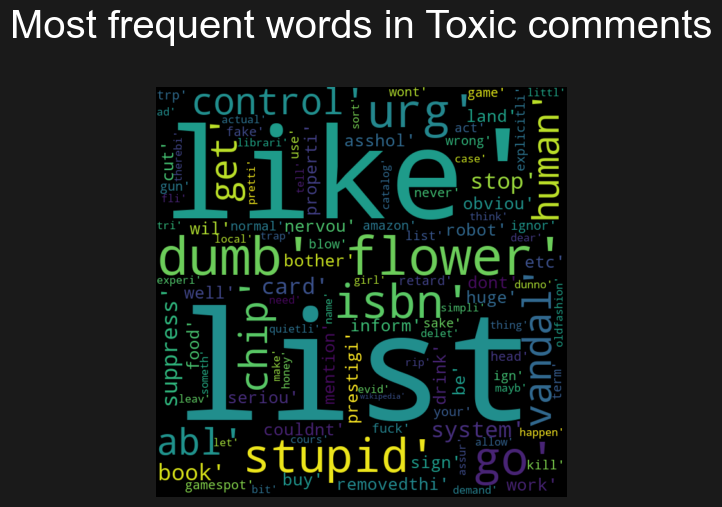

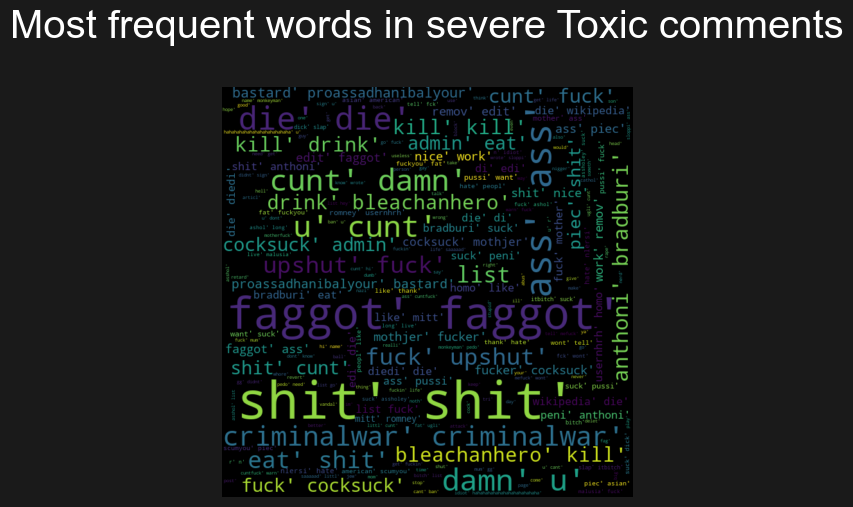

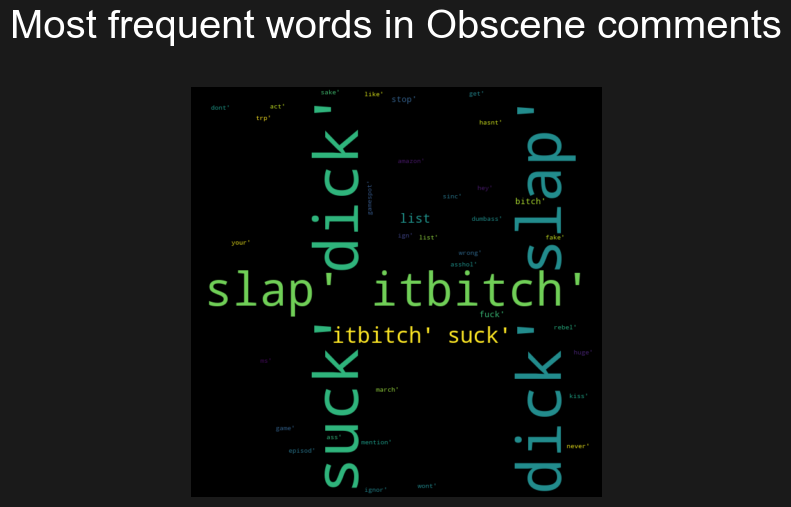

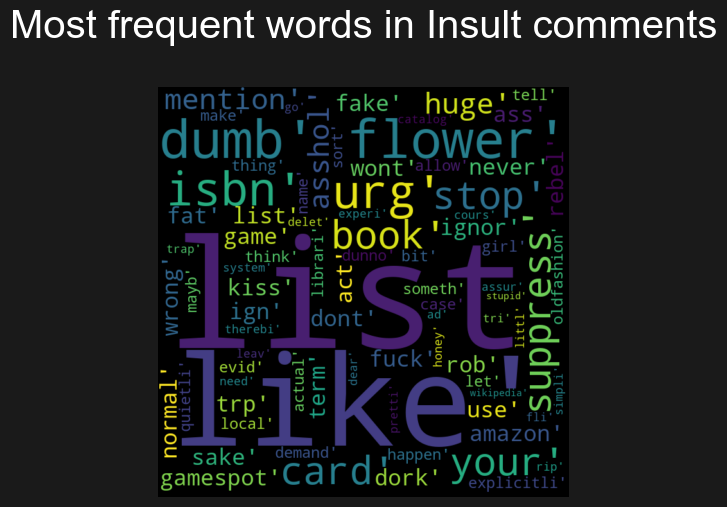

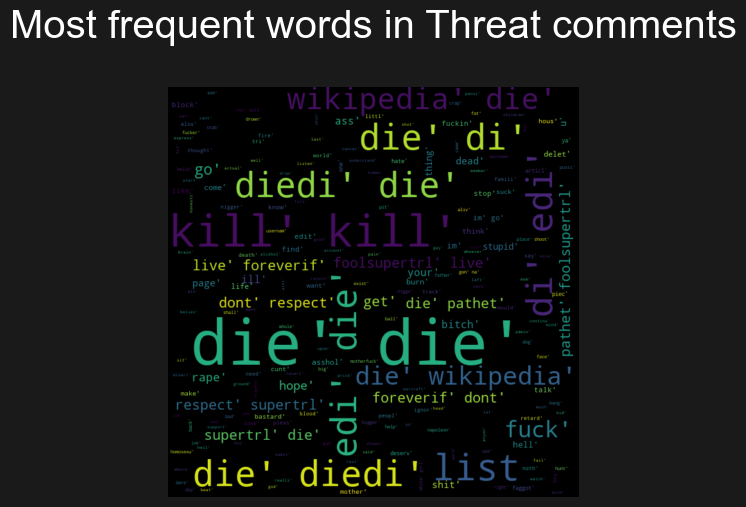

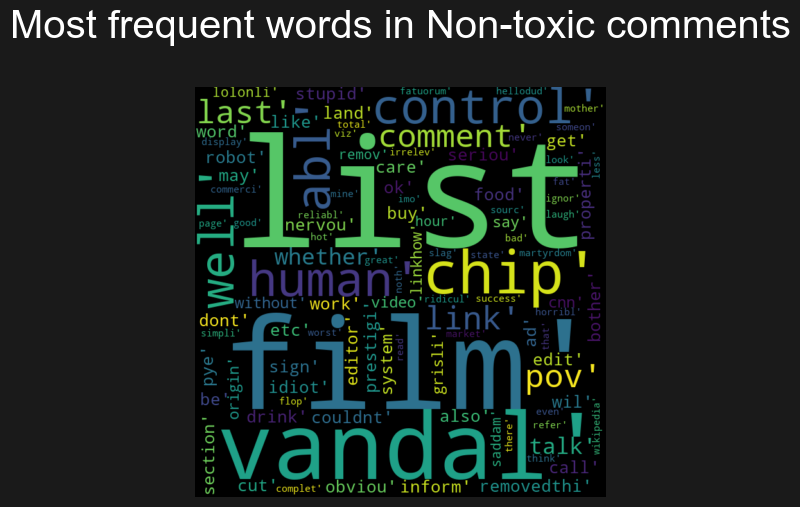

In [37]:
def word_plot(column,text):
    comments = train_data['comment_text'].loc[column == 1].values         
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',stopwords = STOPWORDS).generate(str(comments)) 
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
train_data["Non-toxic"]=train_data["toxic"]+train_data["severe_toxic"]+train_data["obscene"]+train_data["threat"]+train_data["insult"]+train_data["identity_hate"]

word_plot(train_data['toxic'], "Toxic comments")
word_plot(train_data['severe_toxic'],"severe Toxic comments")
word_plot(train_data['obscene'],"Obscene comments")
word_plot(train_data['insult'],"Insult comments")
word_plot(train_data['threat'],"Threat comments")
word_plot(train_data["Non-toxic"],"Non-toxic comments")

## **CLASSIFICATION MODELS**

In [38]:
train_data['comment_text']=train_data['comment_text'].apply(lambda x: ' '.join(x))

In [41]:
def classification_models(X_train,X_test,y_train,y_test):
    
    #random forest classifier
    rf=RandomForestClassifier(n_estimators=300,random_state=5,max_depth=100)
    rf.fit(X_train,y_train)
    y_pred_rf = rf.predict(X_test)
    acc_rf=accuracy_score(y_test,y_pred_rf)
    pr_rf=precision_score(y_test,y_pred_rf)
    rc_rf=recall_score(y_test,y_pred_rf)
    f1_rf=f1_score(y_test,y_pred_rf)
    
    #support vector classifier
    svml=SVC(kernel='linear',C=2.0,random_state=500)
    svml.fit(X_train,y_train)
    y_pred_svc=svml.predict(X_test)
    acc_svc=accuracy_score(y_test,y_pred_svc)
    pr_svc=precision_score(y_test,y_pred_svc)
    rc_svc=recall_score(y_test,y_pred_svc)
    f1_svc=f1_score(y_test,y_pred_svc)

    #knn
    knn=KNeighborsClassifier(algorithm='auto',leaf_size=20, n_neighbors=3)
    knn.fit(X_train,y_train)
    y_pred_knn=knn.predict(X_test)
    acc_knn=accuracy_score(y_test,y_pred_knn)
    pr_knn=precision_score(y_test,y_pred_knn)
    rc_knn=recall_score(y_test,y_pred_knn)
    f1_knn=f1_score(y_test,y_pred_knn)

    #decision tree
    dect=DecisionTreeClassifier(criterion="entropy")
    dect.fit(X_train,y_train)
    y_pred_dt=dect.predict(X_test)
    acc_dt=accuracy_score(y_test,y_pred_dt)
    pr_dt=precision_score(y_test,y_pred_dt)
    rc_dt=recall_score(y_test,y_pred_dt)
    f1_dt=f1_score(y_test,y_pred_dt)

    #logistic regression
    log=LogisticRegression(max_iter=100,C=1.0,penalty='l2')
    log.fit(X_train,y_train)
    y_pred_log = log.predict(X_test)
    acc_log=accuracy_score(y_test,y_pred_log)
    pr_log=precision_score(y_test,y_pred_log)
    rc_log=recall_score(y_test,y_pred_log)
    f1_log=f1_score(y_test,y_pred_log)

    #RVVC
    svm_RVVC=SVC(kernel='linear',C=2.0,random_state=500,probability=True)
    svm_RVVC.fit(X_train,y_train)
    log_RVVC=LogisticRegression(max_iter=100,C=1.0,penalty='l2')
    log_RVVC.fit(X_train,y_train)

    Toxiclr=log_RVVC.predict_proba(X_test)[:,1]
    NonToxiclr=log_RVVC.predict_proba(X_test)[:,0]
    Toxicsvc=svm_RVVC.predict_proba(X_test)[:,1]
    NonToxicsvc=svm_RVVC.predict_proba(X_test)[:,0]

    #RVVC = np.argmax(((Toxiclr+Toxicsvc)/2),((NonToxiclr+NonToxicsvc)/2))
    RVVC = np.where((Toxiclr + Toxicsvc) > (NonToxiclr + NonToxicsvc), 1, 0)
    acc_rvvc=accuracy_score(RVVC,y_test)
    pr_rvvc=precision_score(RVVC,y_test)
    rc_rvvc=recall_score(RVVC,y_test)
    f1_rvvc=f1_score(RVVC,y_test)
    
    #comparison of classifier
    classifiers=["LogisticRegression","KNNClassifier","SVC","DecisionTree","RandomForest","RVVC"]
    accuracy_=[acc_log,acc_knn,acc_svc,acc_dt,acc_rf,acc_rvvc]
    df_ac=pd.DataFrame({'Model':classifiers,"Accuracy":accuracy_})
    px.histogram(data_frame=df_ac,x="Model",y="Accuracy",color=classifiers)
    plt.show()
    
    #table
    classifier=["RF","SVC","KNN","DT","LR","RVVC"]
    accuracy=[acc_rf,acc_svc,acc_knn,acc_dt,acc_log,acc_rvvc]
    precision=[pr_rf,pr_svc,pr_knn,pr_dt,pr_log,pr_rvvc]
    recall=[rc_rf,rc_svc,rc_knn,rc_dt,rc_log,rc_rvvc]
    f1score=[f1_rf,f1_svc,f1_knn,f1_dt,f1_log,f1_rvvc]
    data={'Classifier':classifier,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1-Score':f1score}
    df=pd.DataFrame(data)
    print(df.round(2))

**IMBALANCED DATA WITH TF-IDF**

In [42]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
word_vectorizer = TfidfVectorizer()
X_train = word_vectorizer.fit_transform(X_train)
X_test= word_vectorizer.transform(X_test)
classification_models(X_train,X_test,y_train,y_test)

  Classifier  Accuracy  Precision  Recall  F1-Score
0         RF      0.90       0.90    1.00      0.95
1        SVC      0.94       0.95    0.98      0.97
2        KNN      0.88       0.88    1.00      0.93
3         DT      0.92       0.94    0.96      0.95
4         LR      0.93       0.92    1.00      0.96
5       RVVC      0.94       0.99    0.94      0.97


**UNDER SAMPLING WITH TF-IDF**

In [43]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
word_vectorizer = TfidfVectorizer()
X = word_vectorizer.fit_transform(X)
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_rus,y_rus = rus.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.25, random_state=42)
classification_models(X_train,X_test,y_train,y_test)

  Classifier  Accuracy  Precision  Recall  F1-Score
0         RF      0.82       0.81    0.82      0.82
1        SVC      0.87       0.85    0.88      0.87
2        KNN      0.75       0.78    0.68      0.73
3         DT      0.80       0.81    0.78      0.79
4         LR      0.85       0.82    0.91      0.86
5       RVVC      0.87       0.89    0.84      0.87


**SYNTHETIC MINORITY OVERSAMPLING WITH TF-IDF**

In [44]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
word_vectorizer = TfidfVectorizer()
X = word_vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_smote,y_smote = smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)
classification_models(X_train,X_test,y_train,y_test)

  Classifier  Accuracy  Precision  Recall  F1-Score
0         RF      0.97       0.97    0.97      0.97
1        SVC      0.97       0.99    0.94      0.96
2        KNN      0.53       0.89    0.08      0.15
3         DT      0.94       0.95    0.93      0.94
4         LR      0.94       0.93    0.96      0.95
5       RVVC      0.96       0.96    0.96      0.96


**IMBALANCED DATA WITH BOW**

In [82]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
classification_models(X_train,X_test,y_train,y_test)

  Classifier  Accuracy  Precision  Recall  F1-Score
0         RF      0.90       0.89    1.00      0.94
1        SVC      0.94       0.95    0.98      0.97
2        KNN      0.85       0.95    0.88      0.91
3         DT      0.88       0.93    0.93      0.93
4         LR      0.92       0.92    0.99      0.96
5       RVVC      0.94       0.99    0.94      0.97


**UNDER SAMPLING WITH BOW**

In [46]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_rus,y_rus = rus.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
classification_models(X_train,X_test,y_train,y_test)

  Classifier  Accuracy  Precision  Recall  F1-Score
0         RF      0.90       0.89    1.00      0.94
1        SVC      0.93       0.95    0.96      0.96
2        KNN      0.88       0.90    0.97      0.94
3         DT      0.92       0.95    0.95      0.95
4         LR      0.93       0.94    0.99      0.96
5       RVVC      0.93       0.99    0.94      0.96


**SYNTHETIC MINORITY OVERSAMPLED DATA WITH BOW**

In [47]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_smote,y_smote = smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
classification_models(X_train,X_test,y_train,y_test)

  Classifier  Accuracy  Precision  Recall  F1-Score
0         RF      0.90       0.89    1.00      0.94
1        SVC      0.93       0.95    0.96      0.96
2        KNN      0.88       0.90    0.97      0.94
3         DT      0.92       0.95    0.95      0.95
4         LR      0.93       0.94    0.99      0.96
5       RVVC      0.93       0.99    0.94      0.96


# **TESTING**

In [54]:
X = train_data["comment_text"]
y = train_data['Non-Toxic']
word_vectorizer = TfidfVectorizer()
X = word_vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_smote,y_smote = smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)

In [60]:
svm_RVVC=SVC(kernel='linear',C=2.0,random_state=500,probability=True)
svm_RVVC.fit(X_train,y_train)
log_RVVC=LogisticRegression(max_iter=100,C=1.0,penalty='l2')
log_RVVC.fit(X_train,y_train)

LogisticRegression()

TESTING A NON-TOXIC COMMENT

In [125]:
text = train_data['comment_text'][1200]
text

"Funny, I don't feel blocked."

In [126]:
actual_output = train_data['Non-Toxic'][1200]
actual_output

1

In [127]:
X_test = word_vectorizer.transform([text])
Toxiclr=log_RVVC.predict_proba(X_test)[:,1]
NonToxiclr=log_RVVC.predict_proba(X_test)[:,0]
Toxicsvc=svm_RVVC.predict_proba(X_test)[:,1]
NonToxicsvc=svm_RVVC.predict_proba(X_test)[:,0]

RVVC = np.where((Toxiclr + Toxicsvc) > (NonToxiclr + NonToxicsvc), 1, 0)

In [129]:
if(RVVC==1):
    print("Comment is Non-Toxic")
else:
    print("Comment is Toxic")

Comment is Non-Toxic


TESTING A TOXIC COMMENT

In [134]:
text = train_data['comment_text'][78004]
text

"If you don't like it. You can kiss my Rebel ass."

In [135]:
actual_output = train_data['Non-Toxic'][78004]
actual_output

0

In [136]:
X_test = word_vectorizer.transform([text])

Toxiclr=log_RVVC.predict_proba(X_test)[:,1]
NonToxiclr=log_RVVC.predict_proba(X_test)[:,0]
Toxicsvc=svm_RVVC.predict_proba(X_test)[:,1]
NonToxicsvc=svm_RVVC.predict_proba(X_test)[:,0]

RVVC = np.where((Toxiclr + Toxicsvc) > (NonToxiclr + NonToxicsvc), 1, 0)

In [138]:
if(RVVC==1):
    print("Comment is Non-Toxic")
else:
    print("Comment is Toxic")

Comment is Toxic


ENTER A COMMENT TO CHECK TOXICITY

In [160]:
text = "HEY PITCH"
text

'HEY PITCH'

In [161]:
X_test = word_vectorizer.transform([text])

Toxiclr=log_RVVC.predict_proba(X_test)[:,1]
NonToxiclr=log_RVVC.predict_proba(X_test)[:,0]
Toxicsvc=svm_RVVC.predict_proba(X_test)[:,1]
NonToxicsvc=svm_RVVC.predict_proba(X_test)[:,0]

RVVC = np.where((Toxiclr + Toxicsvc) > (NonToxiclr + NonToxicsvc), 1, 0)

In [162]:
if(RVVC==1):
    print("Comment is Non-Toxic")
else:
    print("Comment is Toxic")

Comment is Non-Toxic
